# Upstream Regulator Analysis Package
## Arthritis Case Study
### Wrapper Class "Upstream" in Use

----------------------

Author: Mikayla Webster (m1webste@ucsd.edu)

Date: 9th February, 2018

----------------------

<a id='toc'></a>
## Table of Contents
1. [Background](#background)
2. [Import packages](#import)
3. [Load Networks](#load)
6. [P-value and Z-score Calculation](#pz)
7. [Compare the Ingenuity Article's results to Ours](#comp)
8. [Display Our results](#display)

## Background
<a id='background'></a>

The inspiration for these modules comes from Ingenuity System's [Ingenuity Upstream Regulator Analysis in IPA®](http://pages.ingenuity.com/rs/ingenuity/images/0812%20upstream_regulator_analysis_whitepaper.pdf).

This notebook demonstrates how to use our ura package WITH the use of our "wrapper class" Upstream. This notebook creates an instance of class Upstream, and uses this instance to call all of our module's functions. This requires less module imports and simplifies work flow. This notebook emphasizes the flow of function calls, namely what order you should call functions in order for the workflow to process correctly. If you need further help on how to use a function or what that function's purpose is, see the comments associated with that function in the source code (create_graph.py or stat_analysis.py).

## Import packages
<a id='import'></a>

In [29]:
# import upstream regulator module
import sys
code_path = '../../ura'
sys.path.append(code_path)
import Upstream
import stat_analysis
reload(Upstream)
reload(stat_analysis)

<module 'stat_analysis' from '../../ura\stat_analysis.pyc'>

In [3]:
%matplotlib inline

In [4]:
# User preferences
symbol = 'symbol'
entrez = 'entrez'

ura = Upstream.Upstream(symbol)

## Load Networks
<a id='load'></a>

1. List of all **Transcription Factors** (TF's) or regulators of interest to us
    <br>
    - Our sources are [slowkow](https://github.com/slowkow/tftargets) and [jaspar](http://jaspar.genereg.net/) TF databases
    <br><br>
2. **Background Network**: [STRING human protein interactions network](https://string-db.org/cgi/download.pl?UserId=9BGA8WkVMRl6&sessionId=HWUK6Dum9xC6&species_text=Homo+sapiens)  
    - Filter our background network down to just the sub network of TF's and their targets
    <br><br>
3. User-supplied list of **Differentially Expressed Genes** (DEG's)

In [5]:
# transcription factors
ura.easy_load_TF_list(slowkow_bool=True, jaspar_bool=True)
TF_list = ura.get('TF_list')
print "Number of TF's: " + str(len(TF_list))

Number of TF's: 3983


In [6]:
# background network
filename = "../../background_networks/9606.protein.actions.v10.5.txt"
confidence_filter = 400
ura.load_STRING_to_digraph(filename, confidence_filter)
DG_TF = ura.get('DG_TF')
DG_universe = ura.get('DG_universe')


print "\nNumber of interactions: " + str(len(list(DG_TF.edges())))

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-7374...done.
Finished.
56 input query terms found dup hits:
	[(u'ENSP00000359550', 3), (u'ENSP00000447879', 2), (u'ENSP00000364076', 2), (u'ENSP00000348986', 2),
312 input query terms found no hit:
	[u'ENSP00000376684', u'ENSP00000289352', u'ENSP00000202788', u'ENSP00000373637', u'ENSP00000367802',
Pass "returnall=True" to return complete lists of duplicate or missing query terms.

Number of interactions: 28939


In [7]:
#ura.DG_TF = save_DG_TF
#ura.DG_universe = DG_universe
# differentially expressed genes
DEG_filename = "../../DEG_databases/DE_Coeff_OAvsNormal_OAvsNormal_20171215.csv" 
ura.create_DEG_list(DEG_filename, p_value_filter = 0.05, fold_change_filter = 1)

DEG_list = ura.get('DEG_list')
DG_TF = ura.get('DG_TF')
DEG_full_graph = ura.get('DEG_full_graph')
DEG_to_pvalue = ura.get('DEG_to_pvalue')
DEG_to_updown = ura.get('DEG_to_updown')

print "Number of DEG's: " + str(len(DEG_list))

Number of DEG's: 1456


## P-values and Z-score Calculation
<a id='pz'></a>

1. **P-values**: How relevant is a TF to its DEG targets? Are they connected by chance, or is their connection statistically significant?
    <br>
    1. -log(p-value) for each TF using [scipy.stats.hypergeom.logsf](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.stats.hypergeom.html).
        1. high value = significant connection between this TF and its DEG targets
        2. low value = TF is randomly associated with its DEG targets
        3. zero = None of this TF's targets were DEG's
        4. inf = original p-value was so small that its log is inf. Very high significance.
        <br><br>
2. **Z-scores**: Goal is to predict the activation states of the TF's

    - activation states: interaction type/regulation direction = predicted state
        - activating/up  = activating
        - activating/down = inhibiting
        - inhibiting/up = inhibiting
        - inhibiting/down = activating
        <br><br>
    - unbiased vs biased calculations:
        - **unbiased calculation**: Assume a normal distribution of activating and inhibiting states 
        - **biased calculation**: For the case when you cannot assume a 50-50 split between up/down-regulated targets and activating/inhbiting interactions. Modify our formula to approximate a normal distribution.

In [8]:
# Enrichment of every TF with respect to its targets
ura.tf_target_enrichment_calc()
tf_target_enrichment = ura.get('tf_target_enrichment')

# Enrichment of TF's themselves
ura.tf_enrichment_calc()   
ura.get('tf_enrichment')

TF_ENRICHMENT    4.114487e-12
dtype: float64

In [9]:
ura.tf_zscore(bias_filter = 0.25) # recommended bias filter is 0.25
z_scores = ura.get('z_scores')
z_scores

STAT1       2.840188
CLASP2      2.672612
KNTC1       2.672612
CLIP1       2.672612
CKAP5       2.672612
MAD1L1      2.672612
CENPA       2.672612
BUB3        2.672612
AHCTF1      2.672612
CLASP1      2.672612
ARNTL2      2.645751
NCOR1       2.645751
STAT5A      2.523573
FOXM1       2.500000
STAT5B      2.500000
AKT2        2.500000
TWIST1      2.333333
RBX1        2.333333
JUND        2.333333
PAFAH1B1    2.323790
CUL1        2.309401
WWTR1       2.236068
FBXW11      2.236068
ARNTL       2.182821
RANBP2      2.182821
XPO1        2.182821
NFKBIA      2.121320
CDC20       2.041241
EGR1        2.041241
MYC         2.020726
              ...   
NR2F1      -1.732051
MTA1       -1.732051
PPP2R2A    -1.732051
ID4        -1.732051
TPR        -1.732051
E2F2       -1.732051
HMGB2      -1.732051
KLF6       -1.732051
CREBBP     -1.800000
MED1       -1.889822
SMARCD3    -1.889822
NCOA1      -1.897367
AR         -1.961161
FOSL2      -2.000000
MEF2A      -2.000000
NR2F2      -2.000000
BRCA1      -2

## Display Our Results
<a id='display'></a>
- Display TF's with top z-scores
- Display a histogram to see where specific genes rank among others according to z-score
- Display subnetwork of a particular TF and its targets

In [21]:
top_values = ura.top_values(act=True, abs_value=True, top=10)
display(top_values)

,z-score,(adj) p-value,(log) fold change
STAT1,2.840188,0.826469,0.063822
AHCTF1,2.672612,0.043979,-0.401034
BUB3,2.672612,0.045374,0.264598
CENPA,2.672612,NaN,NaN
MAD1L1,2.672612,0.039497,-0.561039
CKAP5,2.672612,0.866232,-0.071815
CLIP1,2.672612,0.042270,-0.521127
FOXO3,-2.710687,0.000292,-1.125810
GLI2,-2.828427,0.172742,-0.554695
RBL2,-3.162278,0.129498,-0.830733


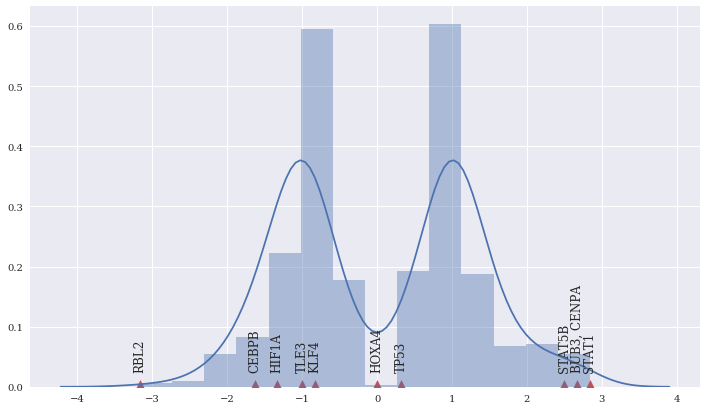

In [33]:
genes_to_rank = ['HOXA4', 'CEBPB', 'HIF1A','KLF4', 'TLE3', 'RBL2','TP53', 'STAT1', 'STAT5B', 'BUB3', 'CENPA']
stat_analysis.compare_genes(z_scores, genes_to_rank)

In [31]:
ura.vis_tf_network('KLF5',
              directed_edges = False,
              node_spacing = 1500,
              color_non_DEGs = False,
              graph_id = 2,
              tf_size_amplifier = -5) 

In [32]:
# display subnetworks using visJS2jupyter
ura.vis_tf_network('STAT1',
              directed_edges = True,
              node_spacing = 2000,
              graph_id = 1,
              tf_size_amplifier = -10) 

In [27]:
# to write data to a csv file
csv_filename = 'URA_Analysis.txt'
ura.to_csv(csv_filename)